## Generative Deep Learning for Drug Discovery
## A baseline model


Present drug discovery endeavors are hindered by a prolonged timeframe, typically spanning 10-15 years, particularly in the case of intricate neurological conditions such as Alzheimer’s disease. This prolonged duration is primarily attributed to the vast chemical landscape, encompassing approximately 10^60 potential drug-like molecules, necessitating extensive exploration. Conventional drug discovery practices often involve the empirical selection of candidate compounds from this expansive chemical space, a method deemed inefficient. However, advancements in deep learning present a promising avenue for expediting the drug discovery process. Recent studies have suggested leveraging deep learning techniques, particularly generative models, to accelerate chemical innovation through natural language processing (NLP) methodologies.
Through innovative neural network architectures and natural language processing techniques, this project seeks to expedite the identification of promising therapeutic compounds, offering hope for faster development of treatments for complex diseases like Alzheimer's

II'll use chembl data, expecially BACE-1 inhibators, and other generic molecules.

BACE-1 inhibitors are compounds that inhibit the activity of the enzyme BACE-1 (Beta-site APP Cleaving Enzyme 1), which is involved in the production of amyloid-beta peptides. These peptides are associated with the development of Alzheimer’s disease¶

### Create and train a baseline model on generic dataset for transfert learning 

In [155]:
import numpy as np
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from keras.models import Sequential

In [4]:
## prepare the data  (data.txt is a file extracted from CHEMBL, it contains generic molecules

DATA_PATH = "c:\\users\\talibit\\Drug_discovery_data\\data.txt"

data = open(DATA_PATH, 'r').read().splitlines()


In [13]:
print(len(data))
print(data[3])
print(data[-1])
print(data[8225])

3538980
CC1COc2c(N3CCN(C)CC3)c(F)cc4C(=O)C(=CN1c24)C(=O)O
COc1ccc(cc1)C(=O)Nc2nnc(s2)S(=O)(=O)Cc3ccccc3
[Cl-].CC(C)(C)C1=CC(=C\C=C\c2cc([te+]c(c2)C(C)(C)C)C(C)(C)C)C=C([Te]1)C(C)(C)C


In [28]:
## remove uncommon letters
new = []
count =0
for molecule in data:
    count+=1
    if 30 < len(molecule) < 50 and count < 300000:
        if ('T' not in molecule) and ('V' not in molecule) and ('g' not in molecule) and ('L' not in molecule) and ('8' not in molecule):
            new.append(molecule)

In [24]:
len(new)

125900

In [29]:
max_seq_len = len(max(new, key=len))
max_seq_len

49

In [70]:
l = [['$']+ list(i) for i in new]
padded = pad_sequences(l, maxlen=max_seq_len+1, padding="post", value="£",dtype=object) 
padded_text =["".join(i) for i in padded]
datas = np.array(padded_text)

In [72]:
print(datas,datas.shape)

['$COc1cc2nc(nc(N)c2cc1OC)N3CCN(CC3)C(=O)c4occc4££££'
 '$CC1COc2c(N3CCN(C)CC3)c(F)cc4C(=O)C(=CN1c24)C(=O)O'
 '$CCN1C=C(C(=O)O)C(=O)c2ccc(C)nc12£££££££££££££££££' ...
 '$OC(CCC(=O)O)CSc1nc(c2ccccc2)c([nH]1)c3ccccc3£££££'
 '$Oc1nc2CCN(Cc3ccncc3)Cc2c4nc(cn14)c5ccccc5F£££££££'
 '$CN1CCN(CC1)c2ccc3C(=O)C(=CN(C4CC4)c3c2C)C(=O)O£££'] (125900,)


In [76]:
#split data into training validation and test sets

seed = 1
np.random.seed(seed)
full_train, test = train_test_split(np.array(datas), test_size=0.2, random_state=seed)

train, val = train_test_split(np.array(full_train), test_size=0.1, random_state=seed)

In [80]:
train
# now we'll concatenate all the data to have one long chemical string

array(['$Cc1cc2nc(N)nc(O)c2c3cc(Cl)ccc13££££££££££££££££££',
       '$CCNC(=O)Nc1ncc(SCc2oc(cn2)C(C)(C)C)s1££££££££££££',
       '$CCCCCCc1cc(\\C=C\\C(=O)c2ccc(O)cc2)c(OC)cc1O£££££££', ...,
       '$CCc1nc(ncc1C(=O)Nc2c(C)cccc2C(=O)NC(C)C)C(F)(F)F£',
       '$CN(C)c1ccccc1C[S+]([O-])c2nccn2c3cc(C)ccn3£££££££',
       '$O=C1N(CC#C)c2cscc2S(=O)(=O)N1Cc3ccccc3£££££££££££'], dtype='<U50')

In [146]:
train = ''.join(train) 
val = ''.join(val) 
# so now train and val are a long string where each chemical string starts with $ and ends with £..£

In [141]:
# this function return for a sequence of chars a tuple of (sequence,next char) where each sequence is a window of seqLen characters
# and the next char is the one following the last char of the sequence
#the sequences are built by moving through the whole sequence by stepSize each time
def n_grams(seqLen, stepSize, data):

    input_chars = [] 
    next_char = [] 
    for i in range(0, len(data) - seqLen, stepSize): 
        input_chars.append(data[i : i + seqLen]) 
        next_char.append(data[i + seqLen]) 

    return input_chars, next_char

# the following function prepare data to feed the neural net
def preparation(data, tokenizer):
    tokenizer.fit_on_texts(data) 
    new_data = tokenizer.texts_to_sequences(data) 

    #N-Grams Sequence 
    seqLen = 15 
    stepSize = 1 
    input_chars, next_char = n_grams(seqLen, stepSize, new_data)
  
    #Assemble Validation Datasets 
    x_data = np.array(input_chars) 
    #x_data.flatten() 
    y_data = np.array(next_char) 
    #y_data_2 = np_utils.to_categorical(y_data) 
    return x_data, y_data

def generate_curves(history, filename):
    fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

    axis1.plot(history.history["accuracy"], label='Train', linewidth=3)
    axis1.plot(history.history["val_accuracy"], label='Validation', linewidth=3)
    axis1.set_title('Model accuracy', fontsize=16, color="white")
    axis1.set_ylabel('accuracy')
    axis1.set_xlabel('epoch')
    axis1.legend(loc='lower right')

    axis2.plot(history.history["loss"], label='Train', linewidth=3)
    axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
    axis2.set_title('Model loss', fontsize=16, color="white")
    axis2.set_ylabel('loss')
    axis2.set_xlabel('epoch')
    axis2.legend(loc='upper right')
    plt.savefig(filename)

In [98]:
#cheking the n_grams function
tokenizer = Tokenizer(num_words=None, char_level=True, lower=False) 

tokenizer.fit_on_texts(train) 
new_data = tokenizer.texts_to_sequences(train) 


#N-Grams Sequence 
seqLen = 15 
stepSize = 1 
input_chars, next_char = n_grams(seqLen, stepSize, new_data)

In [95]:
for i in range(10):
    print(input_chars[i] , next_char[i])

[[12], [3], [1], [7], [1], [1], [8], [13], [1], [4], [10], [5], [13], [1], [4]] [6]
[[3], [1], [7], [1], [1], [8], [13], [1], [4], [10], [5], [13], [1], [4], [6]] [5]
[[1], [7], [1], [1], [8], [13], [1], [4], [10], [5], [13], [1], [4], [6], [5]] [1]
[[7], [1], [1], [8], [13], [1], [4], [10], [5], [13], [1], [4], [6], [5], [1]] [8]
[[1], [1], [8], [13], [1], [4], [10], [5], [13], [1], [4], [6], [5], [1], [8]] [1]
[[1], [8], [13], [1], [4], [10], [5], [13], [1], [4], [6], [5], [1], [8], [1]] [11]
[[8], [13], [1], [4], [10], [5], [13], [1], [4], [6], [5], [1], [8], [1], [11]] [1]
[[13], [1], [4], [10], [5], [13], [1], [4], [6], [5], [1], [8], [1], [11], [1]] [1]
[[1], [4], [10], [5], [13], [1], [4], [6], [5], [1], [8], [1], [11], [1], [1]] [4]
[[4], [10], [5], [13], [1], [4], [6], [5], [1], [8], [1], [11], [1], [1], [4]] [3]


## So now we've prapared our data so each element of the training set is a set of 15 consecutive characters (in red) and its label is the next character (in green)

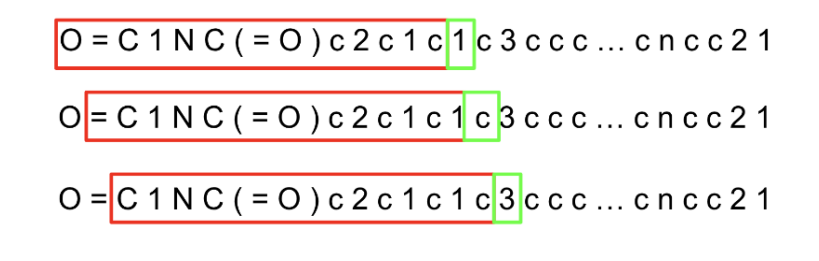

In [107]:
x_train, y_train = preparation(train, tokenizer)

x_val, y_val = preparation(val, tokenizer)


In [112]:
#print(type(x_train),type(y_train),type(x_val),type(y_val))
print("x_train shape :", x_train.shape)
print("y_train shape :", y_train.shape)
print("x_val shape :", x_val.shape)
print("y_val shape :", y_val.shape)

x_train shape : (4532385, 15, 1)
y_train shape : (4532385, 1)
x_val shape : (503585, 15, 1)
y_val shape : (503585, 1)


In [115]:
y_val[0,:]  # so we'll use sparse categorical cross entropy

array([4])

In [124]:
vocab_size = len(tokenizer.word_index)
tokenizer.word_index

{'c': 1,
 '£': 2,
 'C': 3,
 '(': 4,
 ')': 5,
 'O': 6,
 '1': 7,
 '2': 8,
 '=': 9,
 'N': 10,
 '3': 11,
 '$': 12,
 'n': 13,
 '4': 14,
 '[': 15,
 ']': 16,
 '@': 17,
 'H': 18,
 '\\': 19,
 'l': 20,
 'F': 21,
 'S': 22,
 '5': 23,
 's': 24,
 '/': 25,
 '#': 26,
 '+': 27,
 'o': 28,
 '-': 29,
 'B': 30,
 'r': 31,
 'P': 32,
 '.': 33,
 'I': 34,
 '6': 35,
 'a': 36,
 'i': 37,
 'e': 38,
 'p': 39,
 '7': 40,
 'K': 41,
 'A': 42}

In [138]:
baselineLSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(32,input_shape=x_train.shape[1:]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(vocab_size+1, activation='softmax')
])

baselineLSTM.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
print(baselineLSTM.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 43)                1419      
                                                                 
Total params: 5771 (22.54 KB)
Trainable params: 5771 (22.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [140]:
# Train the baseline model
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) 
history = baselineLSTM.fit(x_train, y_train, epochs = 40, batch_size = 128, validation_data=(x_val, y_val), verbose=1, callbacks = [early])
path = "c:\\users\\talibit\\Drug_discovery_data\\models\\baseline_lstm.h5"
path2 = "c:\\users\\talibit\\Drug_discovery_data\\graphs\\baseline_lstm.png"
baselineLSTM.save(path) 
generate_curves(history, path2)

Epoch 1/40
35410/35410 [==============================] - 203s 6ms/step - loss: 1.2408 - accuracy: 0.6061 - val_loss: 1.1388 - val_accuracy: 0.6341
Epoch 2/40
35410/35410 [==============================] - 203s 6ms/step - loss: 1.2198 - accuracy: 0.6117 - val_loss: 1.1239 - val_accuracy: 0.6384
Epoch 3/40
35410/35410 [==============================] - 202s 6ms/step - loss: 1.2066 - accuracy: 0.6152 - val_loss: 1.1128 - val_accuracy: 0.6418
Epoch 4/40
35410/35410 [==============================] - 199s 6ms/step - loss: 1.1975 - accuracy: 0.6177 - val_loss: 1.1065 - val_accuracy: 0.6427
Epoch 5/40
35410/35410 [==============================] - 196s 6ms/step - loss: 1.1901 - accuracy: 0.6195 - val_loss: 1.1031 - val_accuracy: 0.6459
Epoch 6/40
35410/35410 [==============================] - 196s 6ms/step - loss: 1.1847 - accuracy: 0.6210 - val_loss: 1.0982 - val_accuracy: 0.6441
Epoch 7/40
35410/35410 [==============================] - 197s 6ms/step - loss: 1.1797 - accuracy: 0.6224 - val_

C:\Users\talibit\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'generate_curves' is not defined

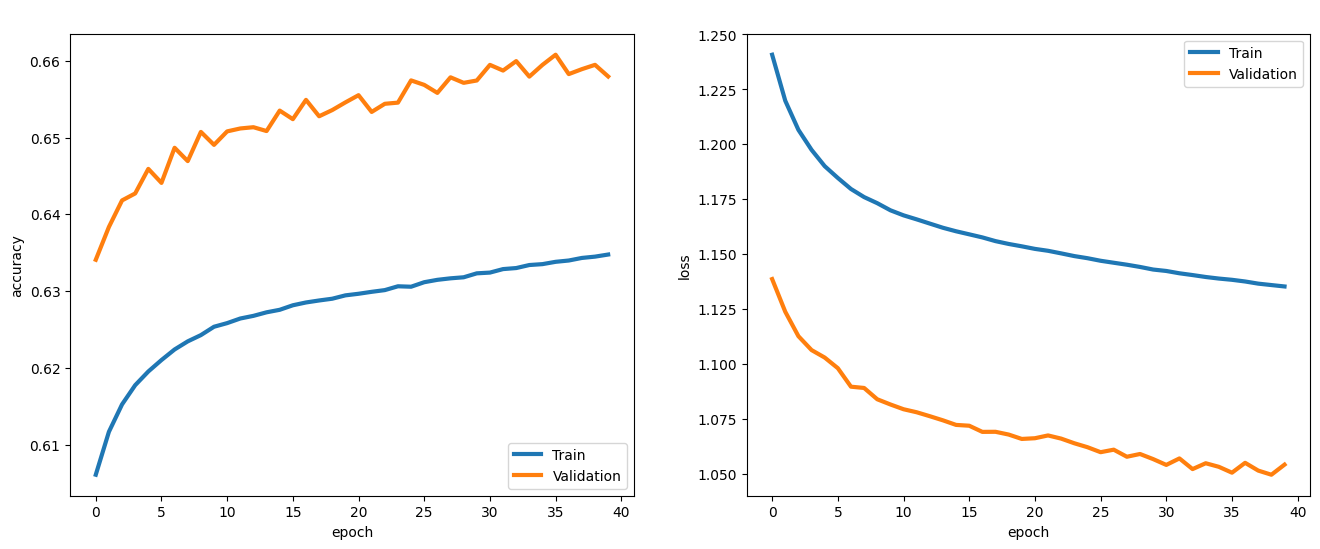

In [145]:
# I added the function generate_curves to supervise accuracy and loss of the model

path = "c:\\users\\talibit\\Drug_discovery_data\\models\\baseline_lstm.h5"
path2 = "c:\\users\\talibit\\Drug_discovery_data\\graphs\\baseline_lstm.png"
baselineLSTM.save(path) 
generate_curves(history, path2)

### Now I'll Train the baseline model on alzheimer dataset without using transfert learning above (without using learned layers of the previous model

In [148]:
DATA_PATH = "c:\\users\\talibit\\Drug_discovery_data\\alzheimersdata.txt"
data = open(DATA_PATH, 'r').read().splitlines()

new = []
count =0
for molecule in data:
    count+=1
    if 30 < len(molecule) < 50 and count < 300000:
        if ('T' not in molecule) and ('V' not in molecule) and ('g' not in molecule) and ('L' not in molecule) and ('8' not in molecule):
            new.append(molecule)
			
max_seq_len = len(max(new, key=len))
print("max_seq_len of alzheimer data set is :", max_seq_len )

l = [['$']+ list(i) for i in new]
padded = pad_sequences(l, maxlen=max_seq_len+1, padding="post", value="£",dtype=object) 
padded_text =["".join(i) for i in padded]
datas = np.array(padded_text)

seed = 1
np.random.seed(seed)
full_train, test = train_test_split(np.array(datas), test_size=0.2, random_state=seed)
train, val = train_test_split(np.array(full_train), test_size=0.1, random_state=seed)

train = ''.join(train) 
val = ''.join(val) 

tokenizer = Tokenizer(num_words=None, char_level=True, lower=False) 

tokenizer.fit_on_texts(train) 
new_data = tokenizer.texts_to_sequences(train) 

input_chars, next_char = n_grams(seqLen, stepSize, new_data)

x_train, y_train = preparation(train, tokenizer)
x_val, y_val = preparation(val, tokenizer)

print("x_train shape :", x_train.shape)
print("y_train shape :", y_train.shape)
print("x_val shape :", x_val.shape)
print("y_val shape :", y_val.shape)


max_seq_len of alzheimer data set is : 49
x_train shape : (30435, 15, 1)
y_train shape : (30435, 1)
x_val shape : (3385, 15, 1)
y_val shape : (3385, 1)


In [149]:
vocab_size = len(tokenizer.word_index)
tokenizer.word_index

{'c': 1,
 '£': 2,
 'C': 3,
 '(': 4,
 ')': 5,
 '1': 6,
 '2': 7,
 'n': 8,
 'O': 9,
 '3': 10,
 '=': 11,
 'N': 12,
 '$': 13,
 '-': 14,
 '[': 15,
 ']': 16,
 '4': 17,
 'H': 18,
 'F': 19,
 'l': 20,
 '/': 21,
 'o': 22,
 'S': 23,
 'B': 24,
 'r': 25,
 '@': 26,
 's': 27,
 '\\': 28,
 '#': 29,
 '+': 30,
 '.': 31,
 '5': 32,
 'I': 33,
 'ï': 34,
 '»': 35,
 '¿': 36,
 'P': 37}

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 43)                1419      
                                                                 
Total params: 5771 (22.54 KB)
Trainable params: 5771 (22.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/60
238/238 [==============================] - 9s 25ms/step - loss: 2.6671 - accuracy: 0.2655 - val_loss: 2.3636 - val_accuracy: 0.3386
Epoch 2/60
238/238 [==============================] - 5s 22ms/step - loss: 2.2927 - accuracy: 0.3391 - val_loss: 2.2047 - val_accuracy: 

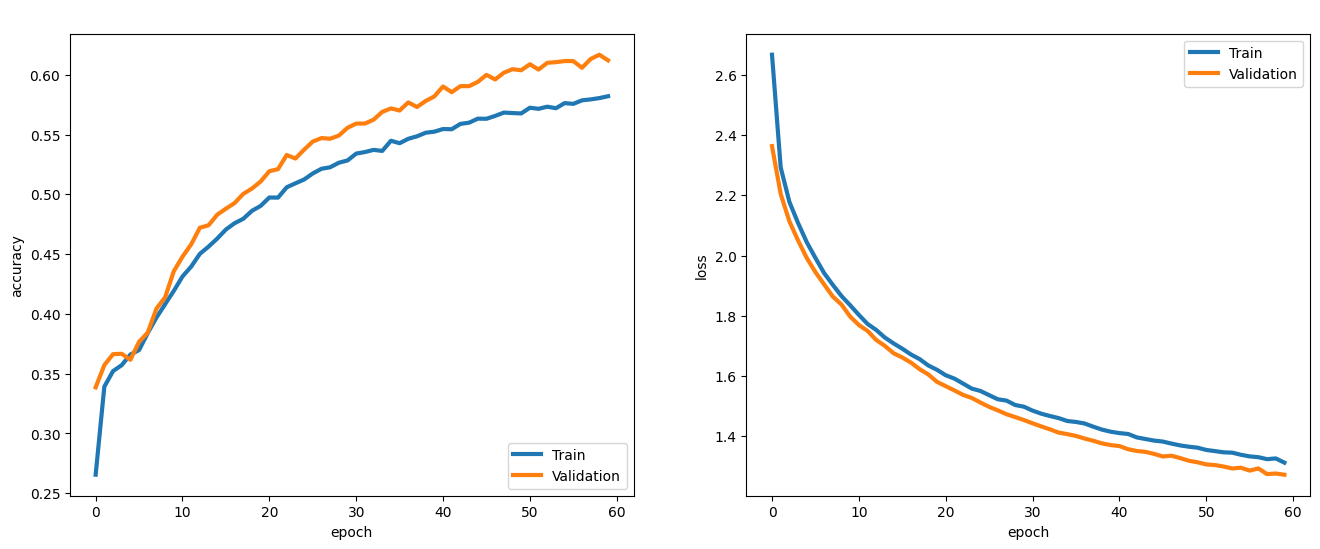

In [150]:
baseline_without_transfert_learning = tf.keras.Sequential([
    tf.keras.layers.LSTM(32,input_shape=x_train.shape[1:]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(vocab_size+1, activation='softmax')
])

baseline_without_transfert_learning.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
print(baselineLSTM.summary())


# Print the model summary

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = baseline_without_transfert_learning.fit(x_train, y_train, epochs = 60, batch_size = 128, validation_data=(x_val, y_val), verbose=1, callbacks = [early])


path = "c:\\users\\talibit\\Drug_discovery_data\\models\\baseline_without_transfert_learning.h5"
path2 = "c:\\users\\talibit\\Drug_discovery_data\\graphs\\baseline_without_transfert_learning.png"
baselineLSTM.save(path) 
generate_curves(history, path2)

### Now i'll train the same model with transfer learning using the baseline model layers (trained on the generic dataset)

[<keras.src.layers.rnn.lstm.LSTM object at 0x00000140403CB520>, <keras.src.layers.regularization.dropout.Dropout object at 0x0000014002AB2970>, <keras.src.layers.core.dense.Dense object at 0x00000140571A0B20>]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 38)                1254      
                                                                 
Total params: 5606 (21.90 KB)
Trainable params: 1254 (4.90 KB)
Non-trainable params: 4352 (17.00 KB)
_________________________________________________________________
Epoch 1/60
238/238 [==============================] - 5s 14ms/step - los

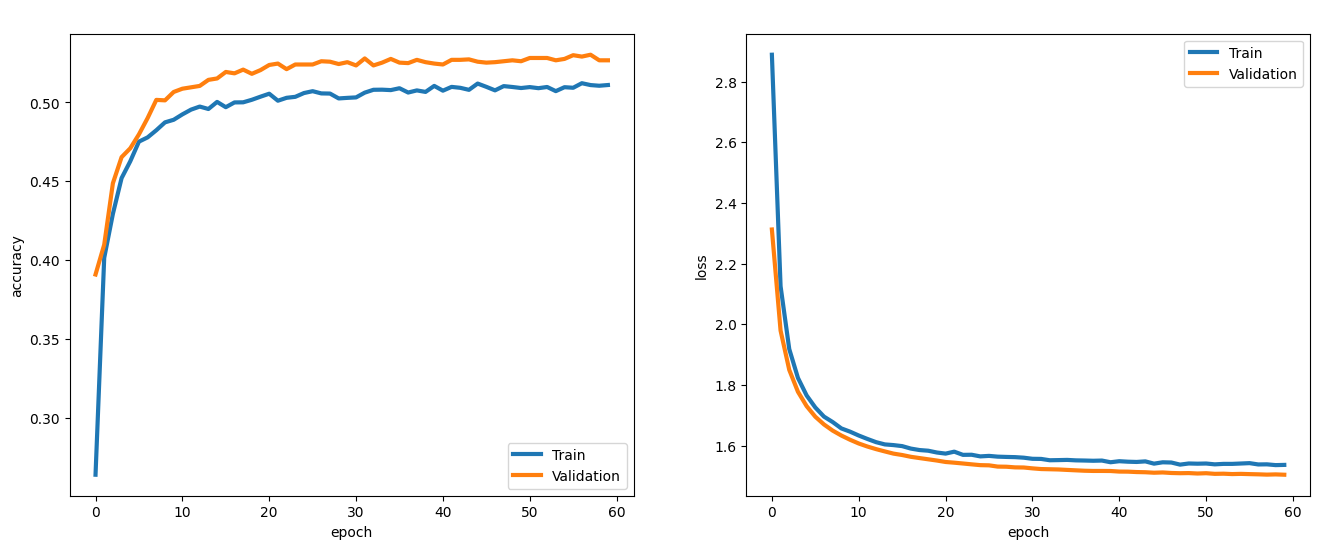

In [156]:
# Transfer Learning Model
baseline = keras.models.load_model("c:\\users\\talibit\\Drug_discovery_data\\models\\baseline_lstm.h5")
baseline_with_transfert_learning = Sequential()
layer_index = 0
for layer in baseline.layers[:-1]:
    if layer_index < 2:
        layer.trainable = False
    
    baseline_with_transfert_learning.add(layer)
    layer_index += 1
    
baseline_with_transfert_learning.add(keras.layers.Dense(units = vocab_size+1, activation='softmax'))
print(baseline_with_transfert_learning.layers)   
baseline_with_transfert_learning .summary()

baseline_with_transfert_learning .compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = baseline_with_transfert_learning.fit(x_train, y_train, epochs = 60, batch_size = 128, validation_data=(x_val, y_val), verbose=1, callbacks = [early])

path = "c:\\users\\talibit\\Drug_discovery_data\\models\\baseline_with_transfert_learning.h5"
path2 = "c:\\users\\talibit\\Drug_discovery_data\\graphs\\baseline_with_transfert_learning.png"
baselineLSTM.save(path) 
generate_curves(history, path2)


In [157]:
# we zoom around the epoch 60 in order to ensure that the loss continues to decrease

def generate_curves_with_zoom(history, filename, zoom_epoch):
    fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

    # Plot accuracy
    axis1.plot(history.history["accuracy"], label='Train', linewidth=3)
    axis1.plot(history.history["val_accuracy"], label='Validation', linewidth=3)
    axis1.set_title('Model accuracy', fontsize=16, color="white")
    axis1.set_ylabel('accuracy')
    axis1.set_xlabel('epoch')
    axis1.legend(loc='lower right')

    # Plot loss
    axis2.plot(history.history["loss"], label='Train', linewidth=3)
    axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
    axis2.set_title('Model loss', fontsize=16, color="white")
    axis2.set_ylabel('loss')
    axis2.set_xlabel('epoch')
    axis2.legend(loc='upper right')

    # Set x-axis limits for loss curve
    axis2.set_xlim(zoom_epoch - 10, zoom_epoch + 10)

    # Save the plot
    plt.savefig(filename)


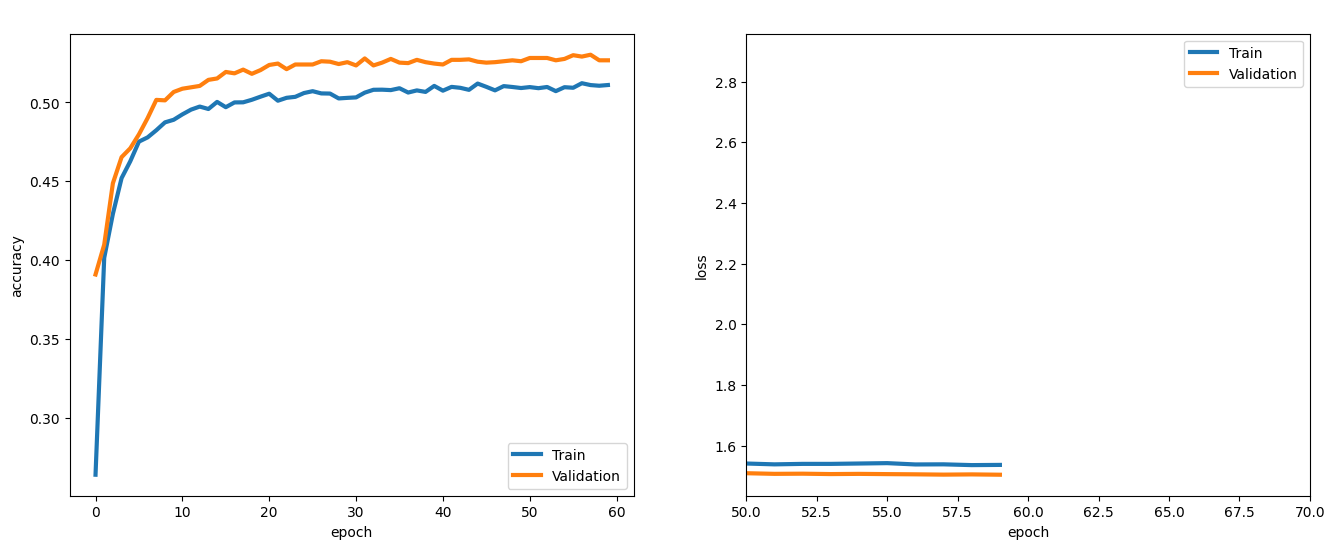

In [159]:
generate_curves_with_zoom(history, path2,zoom_epoch=60)

### Conclusion : the baseline model should be improved for better results. Transfert learning did not enhance performance of the baseline model